In [ ]:
### IMPORTS

import string
import numpy as np
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns

from os import listdir
from re import search, escape, sub
from scipy import integrate

import gspread
from google.colab import auth, drive
from google.auth import default
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
### PATH

experiment_to_analyse = '' # Insert here name of experiment
path = '' # Insert here path to data
corr_coef = 6.9 # Coefficient between different length units

In [ ]:
### ADDITIONALS

def errorfill(x, y, yerr, color=None, alpha_fill=0.3, ax=None, label=None, linewidth = 2):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.plot(x, y, color=color, label=label, linewidth = linewidth)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill)

colordict = {'Brassica': '#8d8089',
             'Pelt': '#50414c',
             'Brinjal': '#5e3a42',
             'Middleton Pink': '#fde7e5',
             'Calluna': '#ccc8ce',
             'Sugaroom Red': '#d0bfcd',
             'Preference Red': '#6d4247',
             'Sulking Room Pink': "#a0837f",
             'Cinder Rose': "#c6a4a6",
             'Nancys Blushes': "#ecb7b8",
             'Rangwali': "#bf7a8f",
             'Lake Red': "#c8526a",
             'Rectory Red': "#a53c49",
             'Incarnadine': "#a04344",
             'Blazer': "#b64f48",
             'Harissa': "#ae5043",
             'Charlottes Locks': "#d65f3d",
             'Book Room': "#ab6758",
             'Red Earth': "#c57b67",
             'India Yellow': "#cb9e59",
             'Sudbury Yellow': "#dcb771",
             'Babouche': "#ecc363",
             'Yellowcake': "#ebe05e",
             'Yellow Ground': "#f2cf86",
             'Dayroom Yellow': "#f7e29d",
             'Dorset Cream': "#efd5a1",
             'Tallow': "#fdedd7",
             'Farrows Cream': "#efdbb3",
             'Hay': "#dec795",
             'Citrona': "#dbcc7c",
             'Churlish Green': "#c8bd83",
             'Yeabridge Green': "#909e6e",
             'Bancha': "#686a47",
             'Duck Green': "#465741",
             'Green Ground': "#dbdab6",
             'Cooking Apple Green': "#c4c6a5",
             'Lichen': "#a1a189",
             'Breakfast Room Green': "#94a68a",
             'Calke Green': "#758769",
             'Emerald Green': "#7bae72",
             'Verdigris': "#3e8b67",
             'Vardo': "#427e83",
             'Arsenic': "#84b59c",
             'Green Smoke': "#737c70",
             'Oval Room Blue': "#8b9d9b",
             'Green Blue': "#acbdb2",
             'Dix Blue': "#99b0ab",
             'Parma Gray': "#b1bfc5",
             'Blue Ground': "#a1c5c8",
             'Stone Blue': "#7997a1",
             'Inchyra Blue': "#586768",
             'Hague Blue': "#3d4e57",
             'Stiffkey Blue': "#4d5b6a",
             'St Giles Blue': "#599ec4",
             'Ultra Marine Blue': "#5d82a1",
             'Cooks Blue': "#6a90b4",
             'Lulworth Blue': "#a0b8c8",
             'Pitch Blue': "#636e8f",
             'Imperial Purple': "#55566b",
             'Scotch Blue': "#41404c",
             'Paean Black': "#494248",
             'Railings': "#45494b",
             'Off Black': "#444546",
             'Pitch Black': "#3b3938",
             'Pigeon': "#a0a093",
             'Old White': "#cec3ad",
             'Strong White': "#e5e0db",
             'Cabbage White': "#e8eeea"}

In [ ]:
### DATA PREPARATION

labels_filename = '' # Insert here name of file with labels
order = gc.open(labels_filename).sheet1
order = order.get_all_values()
order = pd.DataFrame(order)
order.columns = order.iloc[0, :].values.tolist()
order = order.drop(0)
order['ROI number'] = order['ROI number'].astype(int)
order['ROI number'] -= 1
prev = ''
counter = 0
for val_i, val in enumerate(order['Sample']):
  if val in prev:
    counter +=1
  else:

    counter = 0
  outval = f'{val}.{str(counter)}'
  order.iloc[val_i, 1] = outval
  prev = outval

filename = '' # Insert here name of file with data
worksheet = gc.open(filename).sheet1
data = worksheet.get_all_values()
data = pd.DataFrame(data)
data.columns = data.iloc[0,:]
data.drop(0, inplace=True)
data = data.astype('float')
data['Distance (cm)'] = corr_coef * data['Distance_(inches)']
data.set_index('Distance (cm)', inplace = True)
data = data.transpose()
data.drop('Distance_(inches)', inplace = True)
data['old index'] = data.index
data.reset_index(drop=True, inplace = True)
data = data.merge(order, how='inner', left_index=True, right_on='ROI number')

new_data_dict = {'Distance, cm': [],
                 'values': [],
                 'Label_full': []}

for sample in data.Sample.unique():
  for d in data.columns[:-3]:
    value = data[data.Sample == sample][d].values[0]
    new_data_dict['Distance, cm'].append(d)
    new_data_dict['values'].append(value)
    new_data_dict['Label_full'].append(sample)

linear_data = pd.DataFrame(new_data_dict)
linear_data['Label'] = linear_data.apply(lambda row: row['Label_full'].split('.')[0].split(',')[1].strip(), axis = 1)
linear_data['Group'] = linear_data.apply(lambda row: row['Label_full'].split('.')[0].split(',')[0], axis = 1)
linear_data['N'] = linear_data.apply(lambda row: row['Label_full'].split('.')[-1], axis = 1)


linear_data.to_csv(f'{path}{experiment_to_analyse}_profiles.csv', index=False)
linear_data

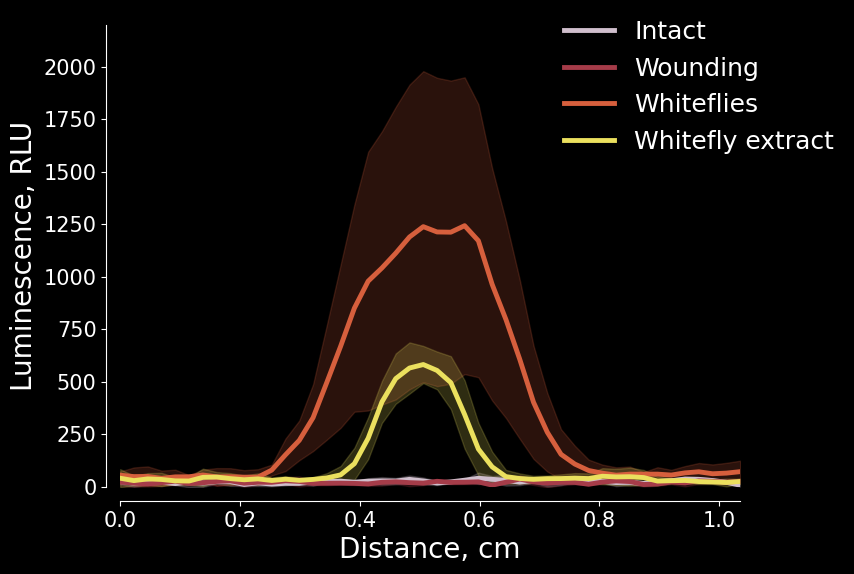

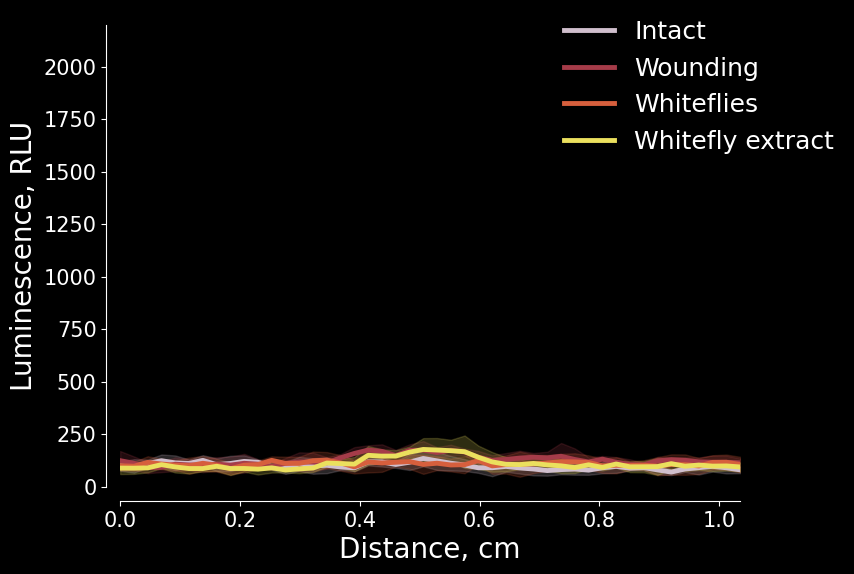

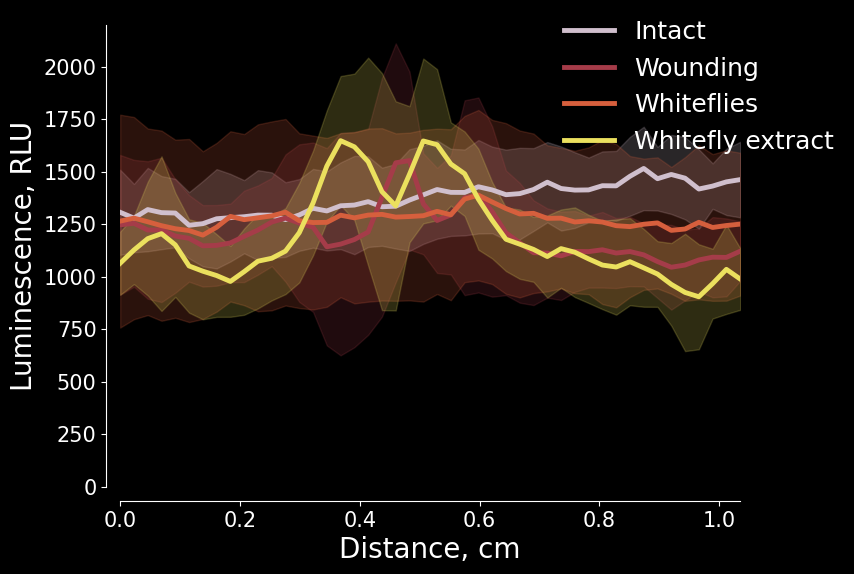

In [ ]:
### PLOTTING

plt.style.use('dark_background')

xlabel_size = 20
ylabel_size = 20
yticklabel_size = 15
xticklabel_size = 15
title_size = 22
suptitle_size = 20
legend_size = 18
signplot_size = 13
titles = {'SA': 'SA-reporting plants',
          'JA': 'JA-reporting plants',
          '35S': 'p35S plants'}

palette_swarm = {
                 'Intact': colordict['Sugaroom Red'],
                  'Wounding': colordict['Rectory Red'],
                 'Whiteflies': colordict['Charlottes Locks'],
                 'Whitefly extract': colordict['Yellowcake'],
    'Non-infiltrated leaf\n$\\it{A.tumefaciens}$': colordict['St Giles Blue']
                 }

linear_data = pd.read_csv(f'{path}exp1401_profiles.csv')
for rep in linear_data.Group.unique():
  fig, ax = plt.subplots(1, figsize = (8, 6))
  part_data = linear_data[linear_data.Group == rep]

  sns.lineplot(data = part_data,
              x = 'Distance, cm',
              y = 'values',
              hue = 'Label',
               hue_order = ['Intact', 'Wounding', 'Whiteflies', 'Whitefly extract'],
               palette = palette_swarm,
              linewidth = 3.5,
              errorbar = 'sd',
              ax = ax)


  ax.tick_params(axis = 'both', which = 'major', labelsize = xticklabel_size)
  ax.set_xlabel('Distance, cm', fontsize = xlabel_size)
  ax.set_ylabel('Luminescence, RLU', fontsize = ylabel_size)
  ax.set_yscale("linear")
  ax.set_xlim(0, part_data['Distance, cm'].max())
  ax.set_ylim(0, 2200)
  ax.legend(loc = [0.7, 0.7], fontsize = legend_size, frameon = False)
  sns.despine(offset = 10, trim = False, ax = ax)

  ver = 'ver4.0'
  plt.savefig(f'{path}{experiment_to_analyse}_{rep}_{ver}.png',
              dpi = 400,
              bbox_inches='tight',
              transparent=False,
              facecolor='black')
  plt.savefig(f'{path}{experiment_to_analyse}_{rep}_{ver}.pdf',
              # dpi = 400,
              bbox_inches='tight',
              transparent=False,
              facecolor='black')

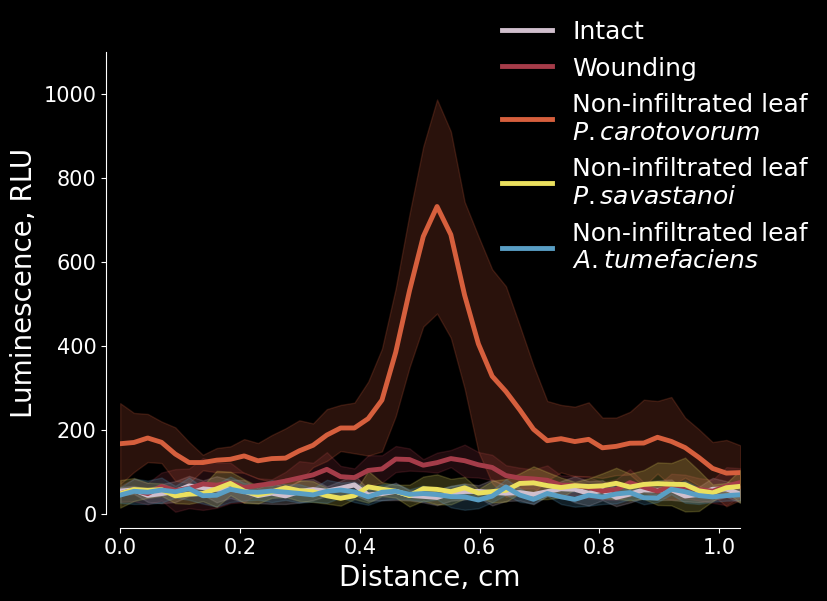

In [ ]:
experiment_to_analyse = 'exp1457'

plt.style.use('dark_background')

xlabel_size = 20
ylabel_size = 20
yticklabel_size = 15
xticklabel_size = 15
title_size = 22
suptitle_size = 20
legend_size = 18
signplot_size = 13

palette_swarm = {
                 'Intact': colordict['Sugaroom Red'],
                  'Wounding': colordict['Rectory Red'],
                 'Non-infiltrated leaf\n$\\it{P.carotovorum}$': colordict['Charlottes Locks'],
                 'Non-infiltrated leaf\n$\\it{P.savastanoi}$': colordict['Yellowcake'],
    'Non-infiltrated leaf\n$\\it{A.tumefaciens}$': colordict['St Giles Blue']
                 }

linear_data = pd.read_csv(f'{path}exp1457_profiles.csv')
fig, ax = plt.subplots(1, figsize = (8, 6))
part_data = linear_data

sns.lineplot(data = part_data,
            x = 'Distance, cm',
            y = 'values',
            hue = 'Label',
            palette = palette_swarm,
            linewidth = 3.5,
            errorbar = 'sd',
            ax = ax)


ax.tick_params(axis = 'both', which = 'major', labelsize = xticklabel_size)
ax.set_xlabel('Distance, cm', fontsize = xlabel_size)
ax.set_ylabel('Luminescence, RLU', fontsize = ylabel_size)
ax.set_yscale("linear")
ax.set_xlim(0, part_data['Distance, cm'].max())
ax.set_ylim(0, 1100)
ax.legend(loc = [0.6, 0.5], fontsize = legend_size, frameon = False)
sns.despine(offset = 10, trim = False, ax = ax)

ver = 'ver4.0'
plt.savefig(f'{path}{experiment_to_analyse}_{ver}.png',
            dpi = 400,
            bbox_inches='tight',
            transparent=False,
            facecolor='black')
plt.savefig(f'{path}{experiment_to_analyse}_{ver}.pdf',
            # dpi = 400,
            bbox_inches='tight',
            transparent=False,
            facecolor='black')

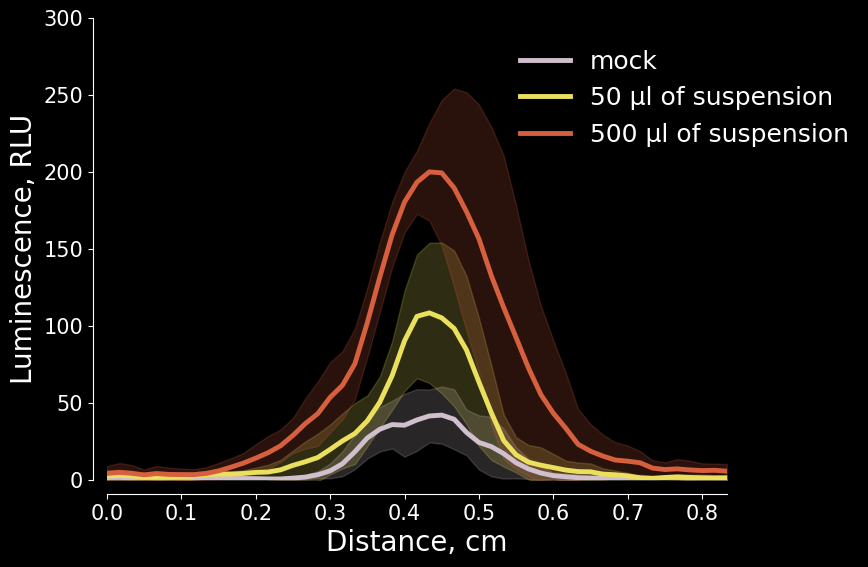

In [ ]:
experiment_to_analyse = 'ara'

plt.style.use('dark_background')

xlabel_size = 20
ylabel_size = 20
yticklabel_size = 15
xticklabel_size = 15
title_size = 22
suptitle_size = 20
legend_size = 18
signplot_size = 13


palette_swarm = {
                 'mock': colordict['Sugaroom Red'],
                 '500 μl of suspension': colordict['Charlottes Locks'],
                 '50 μl of suspension': colordict['Yellowcake']
                 }

linear_data = pd.read_csv(f'{path}ara_profiles.csv')
fig, ax = plt.subplots(1, figsize = (8, 6))
part_data = linear_data

sns.lineplot(data = part_data,
            x = 'Distance, cm',
            y = 'values',
            hue = 'Label',
             palette = palette_swarm,
            linewidth = 3.5,
            errorbar = 'sd',
            ax = ax)


ax.tick_params(axis = 'both', which = 'major', labelsize = xticklabel_size)
ax.set_xlabel('Distance, cm', fontsize = xlabel_size)
ax.set_ylabel('Luminescence, RLU', fontsize = ylabel_size)
ax.set_yscale("linear")
ax.set_xlim(0, part_data['Distance, cm'].max())
ax.set_ylim(0, 300)
ax.legend(loc = [0.65, 0.7], fontsize = legend_size, frameon = False)
sns.despine(offset = 10, trim = False, ax = ax)

ver = 'ver4.0'
plt.savefig(f'{path}{experiment_to_analyse}_{ver}.png',
            dpi = 400,
            bbox_inches='tight',
            transparent=False,
            facecolor='black')
plt.savefig(f'{path}{experiment_to_analyse}_{ver}.pdf',
            # dpi = 400,
            bbox_inches='tight',
            transparent=False,
            facecolor='black')